In [13]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [14]:
import autograd.numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math

In [15]:
def obse_pred_plot(X_mea, X_pred):
    fig, ax = plt.subplots()
    _x = np.linspace( np.min(X_mea), np.max(X_mea), 100 )
    ax.plot(_x, _x, 'r--', label='$x=y$')
    ax.plot(X_mea, X_pred, 'o')
    ax.set_title('Predictions vs Measurements', fontsize=15)
    ax.set_xlabel('Measured', fontsize=15)
    ax.set_ylabel('Predicted', fontsize=15)
    ax.tick_params( labelsize=15 )
    fig.tight_layout()


In [16]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, Matern
from pymanopt.manifolds import Stiefel
from pymanopt.optimizers import ConjugateGradient, SteepestDescent, TrustRegions
from pymanopt import Problem
import pymanopt
from sklearn.model_selection import train_test_split
from scipy.linalg import cholesky, solve_triangular, cho_solve

class grf:
    def __init__(self, X, Y, m_ridge, n_restart=20, tol=1e-2, test_size=0.5):
        """
        X          -- input data
        Y          -- output data
        m_ridge    -- ridge function input dimension
        n_restart  -- number of times to restart fitting and pick the model with the lowest objective function value
        tol        -- error tolerance of cost to stop iteration
        test_size  -- size to split data to train and test sets [0, 1]
        """
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=20)
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.n_restart = n_restart
        self.tol = tol
        dim = X.shape[1] # original dimension
        self.manifold = Stiefel(dim, m_ridge)
        # initialize projection matrix M
        self.M = np.random.rand(dim, m_ridge)
        # initialize covariance kernel
        self.kernel = 1.0 * Matern(length_scale=[1 for _ in range(m_ridge)], nu=2.5) + WhiteKernel(noise_level=1.)
        
    @staticmethod
    def Matern52_manual(X1, X2, length_scale):
        L_inv = np.diag(1. / length_scale.reshape(-1))
        X1_tilde = X1 @ L_inv
        X2_tilde = X2 @ L_inv
        dist = np.sqrt(np.sum(X1_tilde**2,1).reshape(-1,1) + np.sum(X2_tilde**2,1) - 2 * np.dot(X1_tilde, X2_tilde.T) + 1e-9)
        K = np.sqrt(5) * dist
        K = (1.0 + K + K**2 / 3.0) * np.exp(-K)
        return K
    
    @staticmethod
    def Matern32_manual(X1, X2, length_scale):
        L_inv = np.diag(1. / length_scale.reshape(-1))
        X1_tilde = X1 @ L_inv
        X2_tilde = X2 @ L_inv
        dist = np.sqrt(np.sum(X1_tilde**2,1).reshape(-1,1) + np.sum(X2_tilde**2,1) - 2 * np.dot(X1_tilde, X2_tilde.T) + 1e-9)
        K = math.sqrt(3) * dist
        K = (1.0 + K) * np.exp(-K)
        return K
    
    def create_cost(self):
        @pymanopt.function.autograd(self.manifold)
        def cost(M):
            U_train = self.X_train @ M
            U_test = self.X_test @ M

            N_train, m = self.X_train.shape

            lengthscales = self.kernel.get_params()['k1__k2__length_scale'] # Matern lengthscale
            sigma2_f = self.kernel.get_params()['k1__k1__constant_value'] # kernel variance
            sigma2_n = self.kernel.get_params()['k2__noise_level'] # noise variance
            L_inv = np.diag(1. / lengthscales.reshape(-1))
            dim = U_train.shape[1] # dimension of ridge function space

            U_train_tilde = U_train @ L_inv 
            # covariance on training data
            K_train = self.Matern52_manual(U_train_tilde, U_train_tilde, lengthscales)
            G = sigma2_f * K_train + sigma2_n * np.eye(N_train)
            b = np.linalg.solve(G, self.y_train)

            N_test = self.X_test.shape[0]
            U_test_tilde = U_test @ L_inv
            # covariance of testing and training data K(U_test, U_train)
            K_test = sigma2_f * self.Matern52_manual(U_test_tilde, U_train_tilde, lengthscales)
            g_test = K_test @ b
            r = 0.5 * np.linalg.norm(self.y_test - g_test) ** 2 / g_test.shape[0]
            return r
        return cost
    
   
    def pred(self, X_test_pred, return_var=False):
        """ 
        X_test_pred: test points to evaluate ridge function outputs
        M: projection matrix
        kernel: kernel with fitted hyper-parameters
        return_var: whether to return variance at test points
        
        Return:
        g_test: predictions of posterior mean using ridge function
        var_test: posterior variance at test points
        """
        U_train = self.X_train @ self.M
        U_test = X_test_pred @ self.M

        G = self.kernel(U_train)
        L_ = cholesky(G, lower=True, check_finite=False) # lower triangular
        b = cho_solve((L_, True), self.y_train, check_finite=False)

        K_test = self.kernel(U_test, U_train) # covariance of testing and training data
        g_test = K_test @ b # predicted posterior mean
        
        if not return_var:
            return g_test
        else:  
            v = solve_triangular(L_, K_test.T, lower=True, check_finite=False)
            var_test = self.kernel.diag(U_test).copy() - np.einsum("ij,ji->i", v.T, v)
            return g_test, var_test.reshape(-1,1)
            
            
            
    def set_XY(self, X_new, Y_new):
        """
        Update GPR model dataset
        """
        self.X_train = np.vstack((self.X_train, X_new))
        self.y_train = np.vstack((self.y_train, Y_new))
        
    @staticmethod
    def BIC(gpr):
        """
        Return BIC using log-likelihood
        """
        return gpr.log_marginal_likelihood_value_ - 0.5 * (gpr.n_features_in_ + 2) * math.log(gpr.y_train_.shape[0])

    def grf_fit(self):
        last_r =1e10
        err = np.inf
        d, m = self.M.shape
        n_iter = 0
        
        # re-initialize projection matrix M
        V = np.random.randn(d, m)
        q = np.linalg.qr(V)[0]
        self.M = q.copy()
        
        # re-initialize kernel
#         self.kernel = 1.0 * Matern(length_scale=[1 for _ in range(m)], nu=2.5) + WhiteKernel(noise_level=1e-3) 
        
        while err > self.tol:
            self.M_pred = self.M.copy()
            n_iter += 1
            U_train = self.X_train @ self.M_pred
            
            
#             lengthscales = self.kernel.get_params()['k1__k2__length_scale'] # rbf lengthscale
#             sigma2_f = self.kernel.get_params()['k1__k1__constant_value'] # rbf variance
#             sigma2_n = self.kernel.get_params()['k2__noise_level'] # noise variance
            # prior covariance
            ker = 1.0 * Matern(length_scale=[1 for _ in range(m)], length_scale_bounds=(1e-8, 1e7), nu=2.5) \
            + WhiteKernel(noise_level=0.01, noise_level_bounds=(1e-8, 1e-2)) # noise_level: iid noise variance
            
            gpr = GaussianProcessRegressor(kernel=ker, n_restarts_optimizer=20, alpha=1e-7, normalize_y=False) 
            # n_restars_optimizer: number of optimizations for hyper-parameters
            # alpha: adding to diagonal of covariance matrix to prevent numerical issue during fitting
            gpr.fit(U_train, self.y_train)

            self.kernel = gpr.kernel_ # posterior kernel

            my_cost = self.create_cost()
            problem = Problem(manifold=self.manifold, cost=my_cost)
#             optimizer = ConjugateGradient(verbosity=0)
#             optimizer = SteepestDescent(verbosity=0)
            optimizer = TrustRegions(verbosity=0)
            M_new = optimizer.run(problem).point

            r = my_cost(self.M)
            err = np.abs(last_r - r) / last_r
            last_r = r
            self.M = M_new.copy()
        bic = self.BIC(gpr)
        return self.M_pred, gpr, r, bic, n_iter
    
    def __call__(self):
        r_min = np.inf
        for i in range(self.n_restart):
            M, gpr, r, bic, n_iter = self.grf_fit();
            print(i, r)
            if r < r_min:
                M_opt = M.copy()
                gpr_opt = gpr
                bic_opt = bic
                n_final = n_iter
                r_min = r
        self.M = M_opt
        self.kernel = gpr_opt.kernel_
        return M_opt, gpr_opt, r_min, bic_opt, n_final

## Testing linear ridge function
Paper section 4.1

C:\Users\ma516\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)
C:\Users\ma516\Anaconda3\lib\site-packages\autograd\numpy\numpy_vjps.py:99: RuntimeWarning: invalid value encountered in power
  defvjp(anp.sqrt,    lambda ans, x : lambda g: g * 0.5 * x**-0.5)
C:\Users\ma516\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in power
  return f_raw(*args, **kwargs)
C:\Users\ma516\Anaconda3\lib\site-packages\autograd\numpy\numpy_vjps.py:59: RuntimeWarning: invalid value encountered in power
  lambda ans, x, y : unbroadcast_f(x, lambda g: g * y * x ** anp.where(y, y - 1, 1.)),


0 0.005157739579125043
1 0.310143785036337
2 0.00517472960361582
3 0.00517560759517238


C:\Users\ma516\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)
C:\Users\ma516\Anaconda3\lib\site-packages\autograd\numpy\numpy_vjps.py:99: RuntimeWarning: invalid value encountered in power
  defvjp(anp.sqrt,    lambda ans, x : lambda g: g * 0.5 * x**-0.5)
C:\Users\ma516\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in power
  return f_raw(*args, **kwargs)
C:\Users\ma516\Anaconda3\lib\site-packages\autograd\numpy\numpy_vjps.py:59: RuntimeWarning: invalid value encountered in power
  lambda ans, x, y : unbroadcast_f(x, lambda g: g * y * x ** anp.where(y, y - 1, 1.)),


4 nan


<IPython.core.display.Javascript object>


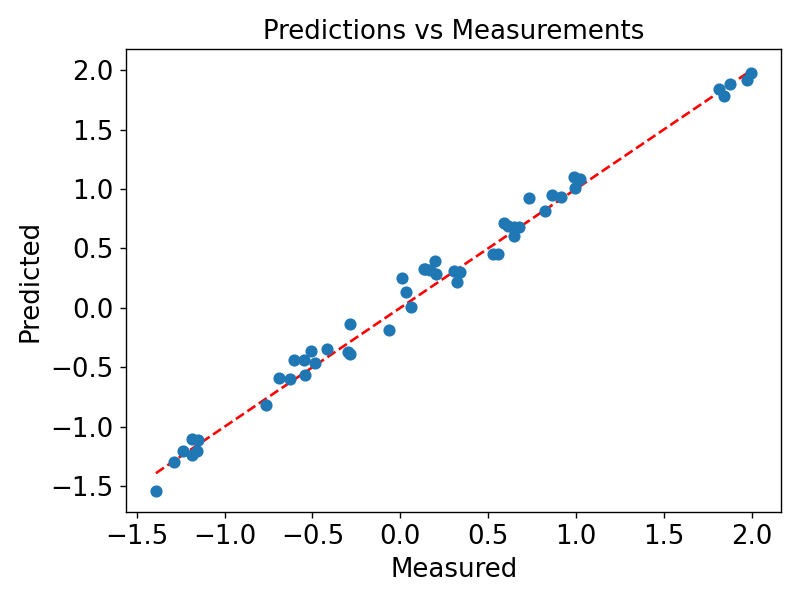

In [5]:
# get training and testing data
d = 10 # dimension of input
m = 2 # ridge subspace dimension
N = 100
X = np.random.rand(N, d) * 2 - 1 # x in [-1,1]
X_test = np.random.rand(50, d) * 2 - 1
# training and testing data
Ureal = np.random.randn(d, m)
q = np.linalg.qr(Ureal)[0]
Ureal = q.copy() # orthogonal
U_data = X @ Ureal
U_test = X_test @ Ureal
Y = np.sum(U_data, axis=1)
y_test = np.sum(U_test, axis=1)
grf_test = grf(X, Y, 2, n_restart=5, tol=1e-1, test_size=0.5)
results_grf = grf_test()
M_final, gpr_final, r_final, bic_final, n_final = results_grf
obse_pred_plot(y_test, grf_test.pred(X_test))

<IPython.core.display.Javascript object>


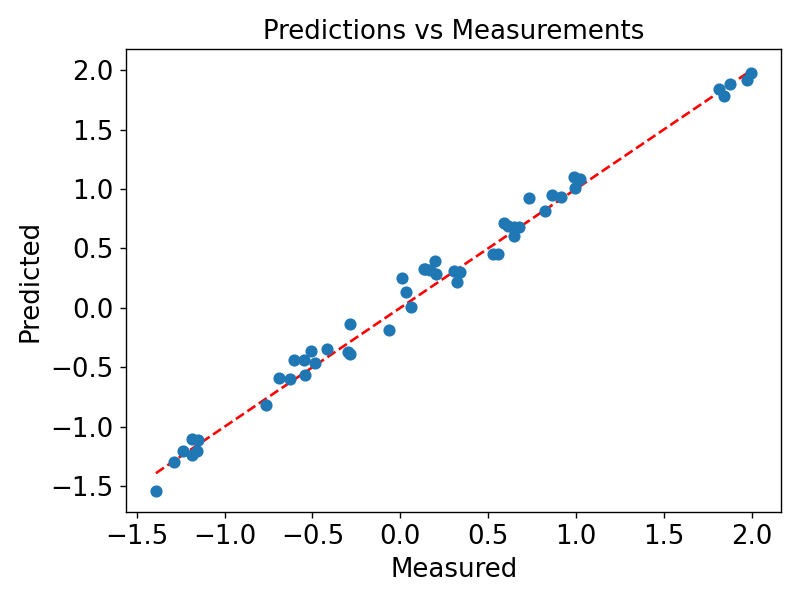

In [7]:
M_final, gpr_final, r_final, bic_final, n_final = results_grf
obse_pred_plot(y_test, grf_test.pred(X_test))

In [8]:
bic = results_grf[4]
r = results_grf[2]
print(f'cost={r}')
print(f'BIC = {bic}')

cost=0.005157739579125043
BIC = 5


<IPython.core.display.Javascript object>


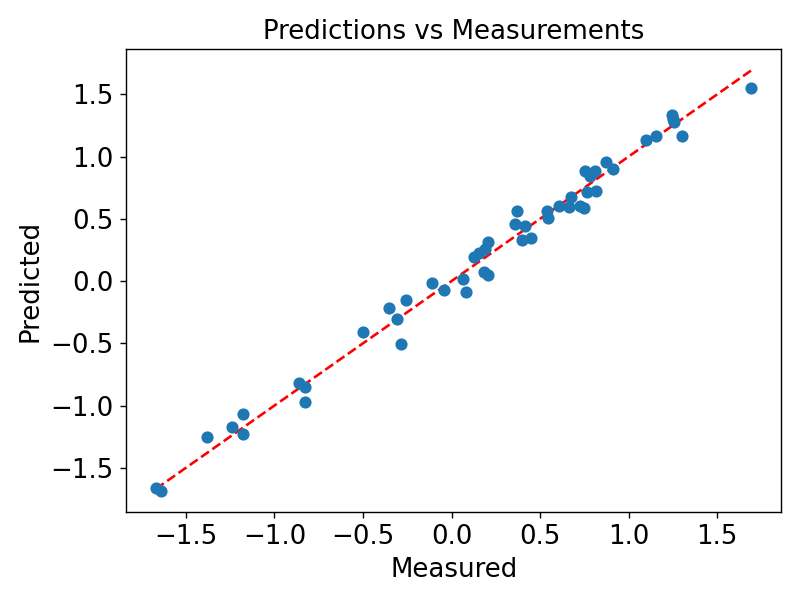

In [10]:
# performance on validation data only
obse_pred_plot(grf_test.y_train, grf_test.pred(grf_test.X_train))

<IPython.core.display.Javascript object>


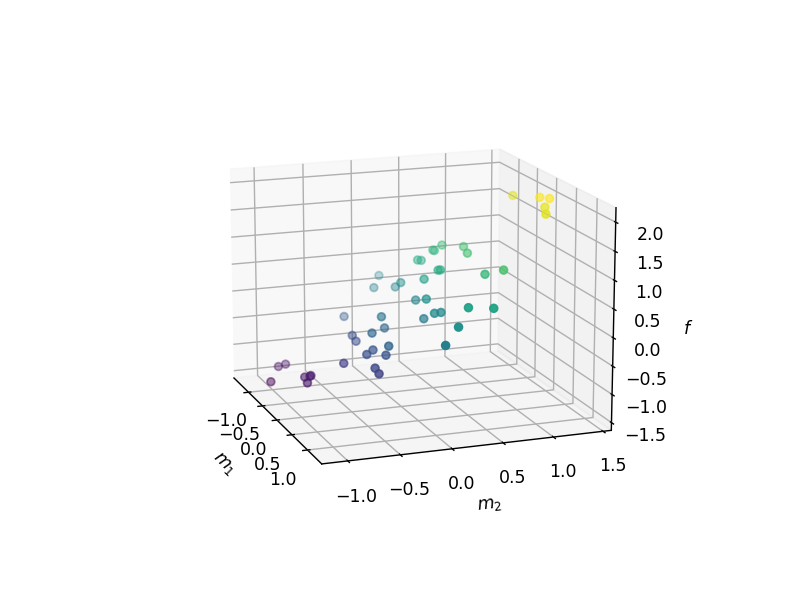

In [12]:
# plot ridge function
ax = plt.figure().add_subplot(projection='3d')
U_test_final = X_test @ M_final # using optimized M
ax.scatter(U_test_final[:,0], U_test_final[:,1], y_test, c=y_test)
# ax.invert_yaxis()
ax.set_xlabel('$m_1$')
ax.set_ylabel('$m_2$')
ax.set_zlabel('$f$')
plt.show()

### Turbomachinery case study

In [ ]:
# load data
X_train = np.loadtxt('bladeA_cs_training_inputs.dat')
X_test = np.loadtxt('bladeA_cs_validation_inputs.dat')
y_train = np.loadtxt('bladeA_cs_training_outputs.dat')
y_test = np.loadtxt('bladeA_cs_validation_outputs.dat')
grf_test = grf(X_train, y_train, 2, n_restart=10, tol=1e-3, test_size=0.5)
results_grf = grf_test()
M_final, gpr_final, r_final, bic_final, n_final = results_grf
obse_pred_plot(grf_test.y_test, grf_test.pred(grf_test.X_test))

In [ ]:
# plot ridge function
ax = plt.figure().add_subplot(projection='3d')
U_test_final = grf_test.X_test @ grf_test.M 
ax.scatter(U_test_final[:,0], U_test_final[:,1], grf_test.y_test, c=grf_test.y_test)
# ax.invert_yaxis()
ax.set_xlabel('$m_1$')
ax.set_ylabel('$m_2$')
ax.set_zlabel('$f$')
plt.show()

### Bayesian Optimization for chiller model calibration

In [ ]:
from dymola.dymola_interface import DymolaInterface
dymola = None
dymola = DymolaInterface()
dymola.openModel(path="C:\Jiacheng Ma\Modelica libraries\DynamicVCC\DynamicVCC\package.mo",changeDirectory=False)

In [ ]:
def L_HX(theta_in):
    problem = "DynamicVCC.Examples.Chiller.Cycle"
    startTime = 2000
    stopTime = 5000
    outputInterval = 10
#     numberOfIntervals = 500
    method = "Dassl"
    tolerance = 0.0001
    initialNames = ['u[{}]'.format(i) for i in range(1,len(theta_in)+1)]
    initialValues = theta_in
    dymola.experimentSetupOutput(events=False)
    result, finalVar = dymola.simulateExtendedModel(problem=problem,
                                          startTime=startTime, 
                                          stopTime=stopTime,
                                          outputInterval=outputInterval,
                                          method=method,
                                          tolerance=tolerance,
                                          initialNames=initialNames,
                                          initialValues=initialValues)
    if not result:
        print(theta_in)
        print("Simulation failed. Below is the translation log.")
        log = dymola.getLastErrorLog()
        print(log)
        exit(1)
        return None, None
    else:
        Nrows = dymola.readTrajectorySize("dsres.mat")
        outputNames = ['y[{}]'.format(i) for i in range(1,8)] + ['y_mea[{}]'.format(i) for i in range(1,8)]
        outputVar = dymola.readTrajectory("dsres.mat", outputNames, Nrows)
        pred = np.array(outputVar[:7])
        Mea = np.array(outputVar[7:])
        ner = np.linalg.norm(pred[:,10:] - Mea[:,10:], axis=1) / np.linalg.norm(Mea[:,10:], axis=1) # omit some initialization points
        W = np.eye(ner.shape[0])
        cost = np.dot(ner.T,W.dot(ner))
        return cost, outputVar

# Objective function to minimize
def J_calib(u, lb, ub):
    """
    u    -- Scaled HTC
    lb   -- HTC lower bound
    ub   -- HTC upper bound
    """
    u_truescale = np.round(lb + u * (ub - lb),1)
    cost, outputVar = L_HX(list(u_truescale))
    if not cost:
        exit(1)
    else:
        return -np.log(cost)

In [ ]:
if dymola is not None:
    dymola.close()
    dymola = None

In [ ]:
# Test dymola model
theta_test = [5e4, 8e4, 5e4, 2e4, 131146, 5e4, 8e4, 5e4, 2e4, 123886.44, 100]
# theta_test = [789625.0, 888625.0, 344125.0, 712787.5, 83605.6, 616375.0, 566875.0, 888625.0, 702787.5, 147888.0, 126.2]
cost, outputVar = L_HX(theta_test)

In [ ]:
fig, ax = plt.subplots()
ax.plot(outputVar[3])

Lower and upper bounds for calibration parameters

In [ ]:
# lb = np.array([1e4, 1e4, 1e4, 1e3, 65573, 1e4, 1e4, 1e4, 1e3, 61943, 50]) # Lower bounds of input space
# ub = np.array([1e6, 1e6, 1e6, 1e6, 196719, 1e6, 1e6, 1e6, 1e6, 247770, 150]) # Upper bounds of input space
lb = np.array([1233.3, 1233.3, 1233.3, 1365.4, 65573, 8867.3, 8867.3, 8867.3, 6118.9, 61943, 50])
ub = np.array([123330, 123330, 123330, 136540, 196719, 886730, 886730, 886730, 611890, 247770, 150])

Use Latin Hypercube designs to generate random samples

In [ ]:
# Generate some starting data
np.random.seed(12345) # repeatable
n_init = 100 # Number of data points

from pyDOE import lhs

# Generate scaled samples of the input space
# X_normalize = np.random.rand(n_init, len(lb))
X_normalize = lhs(len(lb), n_init, 'c')

# Get corresponding results at function space
Y = np.zeros(n_init)
for i in range(n_init):
    Y[i] = J_calib(X_normalize[i,:], lb, ub)
    print(i+1, Y[i])
X_normalize = X_normalize[~np.isnan(Y),:]
Y = Y[~np.isnan(Y)]

# Plot funciton values
fig, ax = plt.subplots()
ax.plot(Y,'kx',markersize=10, markeredgewidth=2)
ax.set_xlabel('$n$')
ax.set_ylabel('$J(u)$')

# save data
# np.savetxt('YX_ChillerCycle.txt', np.hstack((Y[:,None], X_normalize)), delimiter=',')

Gaussian ridge function for calibration parameter space

In [17]:
YX_data = np.loadtxt('YX_ChillerCycle.txt', delimiter=',')
Y = YX_data[:200,0]
X_normalize = YX_data[:200,1:]

# normalize training data
from sklearn import preprocessing
scaler_y = preprocessing.StandardScaler().fit(Y.reshape(-1,1))
Y_scaled = scaler_y.transform(Y.reshape(-1,1))

X_scaled = X_normalize
# scaler_X = preprocessing.StandardScaler().fit(X_normalize)
# X_scaled = scaler_X.transform(X_normalize)

In [18]:
grf_HX = grf(X_scaled, Y_scaled, 2, n_restart=10, tol=1e-1, test_size=0.5)
results_HX = grf_HX()
M_final, gpr_final, r_final, bic_final, n_final = results_HX
obse_pred_plot(Y, scaler_y.inverse_transform(grf_HX.pred(X_scaled)))

C:\Users\ma516\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)
C:\Users\ma516\Anaconda3\lib\site-packages\autograd\numpy\numpy_vjps.py:99: RuntimeWarning: invalid value encountered in power
  defvjp(anp.sqrt,    lambda ans, x : lambda g: g * 0.5 * x**-0.5)
C:\Users\ma516\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in power
  return f_raw(*args, **kwargs)
C:\Users\ma516\Anaconda3\lib\site-packages\autograd\numpy\numpy_vjps.py:59: RuntimeWarning: invalid value encountered in power
  lambda ans, x, y : unbroadcast_f(x, lambda g: g * y * x ** anp.where(y, y - 1, 1.)),


0 nan


C:\Users\ma516\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)
C:\Users\ma516\Anaconda3\lib\site-packages\autograd\numpy\numpy_vjps.py:99: RuntimeWarning: invalid value encountered in power
  defvjp(anp.sqrt,    lambda ans, x : lambda g: g * 0.5 * x**-0.5)
C:\Users\ma516\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in power
  return f_raw(*args, **kwargs)
C:\Users\ma516\Anaconda3\lib\site-packages\autograd\numpy\numpy_vjps.py:59: RuntimeWarning: invalid value encountered in power
  lambda ans, x, y : unbroadcast_f(x, lambda g: g * y * x ** anp.where(y, y - 1, 1.)),


KeyboardInterrupt: 

In [ ]:
# expectation of variance
g_pred, var_pred = grf_HX.pred(grf_HX.X_test, return_var=True)
E_var = np.mean(var_pred)
print(f'Expectation of posterior variance: {E_var}')

In [ ]:
# performance only on training data
obse_pred_plot(scaler_y.inverse_transform(grf_HX.y_train), scaler_y.inverse_transform(grf_HX.pred(grf_HX.X_train)))

In [ ]:
# compare gpr.predict() method and grf.pred() method
y_train_predict = scaler_y.inverse_transform(gpr_final.predict(grf_HX.X_train @ M_final))
y_train_pred = scaler_y.inverse_transform(grf_HX.pred(grf_HX.X_train))
obse_pred_plot(y_train_pred, y_train_predict)
# for using gpr.predict, input should be projected onto M_final, which is used for training

In [ ]:
# performance only on testing data
X_test = grf_HX.X_test
y_test_scaled = grf_HX.y_test
obse_pred_plot(scaler_y.inverse_transform(y_test_scaled), scaler_y.inverse_transform(grf_HX.pred(grf_HX.X_test)))

In [ ]:
print(f'r={results_HX[2]}')
print(f'BIC={results_HX[3]}')

In [ ]:
gpr_final.kernel_

### Bayesian optimization

In [ ]:
def BGOmaximize(f, gpr, X_design, alpha, f_params={}, alpha_params={}, max_it=15, plot=False):
    """Optimize a function using Bayesian global optimization
    Arguments
    f              -- The function to optimize
    gpr            -- Gaussian process regression model to approximate the objective function
    X_design       -- The set of candidate points to evaluate the function for identifying the optimal point
    alpha          -- Information acquisition function
    alpha_params   -- Extra parameters to the information acquisition function
    max_it         -- The maximum number of iterations
    plot           -- Whether or not to plot function evaluations v.s. iterations at max_it
    """
    af_all = [] # Store values of acquisition function 
    x_all = []
    y_all = []
    for count in range(max_it):
        # Using GPR model to get posterior mean and variance at given design points
        g, var = gpr.pred(X_design, return_var=True) # posterior mean and variance
        # Evaluate information acquisition function
        af_values = alpha(g, np.sqrt(var), gpr.y_train.max(), **alpha_params)
        # Find index of the next point to evaluate
        i = np.argmax(af_values)
        # Evaluate the function and stack the new data point to observations
        x_new = X_design[i,:] # original input space, not ridge function input space
        y_new = f(x_new, **f_params)
        print(count+1, x_new, y_new)
        if not y_new:
            X_design = np.delete(X_design, i, axis=0)
        else:
            x_all.append(x_new)
            y_all.append(y_new)
            af_all.append(af_values[i])
            # Update GPR
            y_new_scaled = scaler_y.transform(y_new.reshape(-1,1))
            gpr.set_XY(x_new, y_new_scaled)
            
    if plot:
        fig, ax = plt.subplots()
        ax.plot(y_all, '-*', markersize=10, markeredgewidth=2)
        ax.set_xticks(range(1,max_it+1,2))
        ax.set_xlabel('Iterations')
        ax.set_ylabel('$f(x)$')
            
    return gpr, af_all, x_all, y_all

# maximum upper interval
def mui(m, sigma, ymax, psi=1.96):
    return m + psi * sigma

In [ ]:
n_design = int(1e7)
max_it=30 # number of iterations
X_design_normalize = np.random.rand(n_design, len(lb))
gpr_grf, af_all, x_all, y_all = BGOmaximize(J_calib, grf_HX, X_design_normalize, mui, f_params={'lb':lb,'ub':ub},max_it=max_it, plot=1)

In [ ]:
x_optimal = x_all[-1]
u_optimal = np.round(lb + x_optimal * (ub - lb),1)

In [ ]:
cost, outputVar = L_HX(list(u_optimal))

### Plot chiller transient response

In [ ]:
fig, ax = plt.subplots(4,1, figsize=(8,10))
time = np.linspace(2100, 3500, 141)
# pressures
ax[0].plot(time, np.array(outputVar[0][10:]) / 1e3, '-', linewidth=1.5, label='Suction (Predicted)')
ax[0].plot(time, np.array(outputVar[7][10:]) / 1e3, '--', linewidth=1.5, label='Suction (Measured)')
ax[0].plot(time, np.array(outputVar[1][10:]) / 1e3, '-', linewidth=1.5, label='Discharge (Predicted)')
ax[0].plot(time, np.array(outputVar[8][10:]) / 1e3, '--', linewidth=1.5, label='Discharge (Measured)')
ax[0].set_ylabel('Pressure [kPa]')
ax[0].grid()
ax[0].legend(fontsize='small', loc='best')
# water temperatures
ax[1].plot(time, np.array(outputVar[2][10:]), '-', linewidth=1.5, label='Evaporator (Predicted)')
ax[1].plot(time, np.array(outputVar[9][10:]), '--', linewidth=1.5, label='Evaporator (Measured)')
ax[1].plot(time, np.array(outputVar[3][10:]), '-', linewidth=1.5, label='Condenser (Predicted)')
ax[1].plot(time, np.array(outputVar[10][10:]), '--', linewidth=1.5, label='Condenser (Measured)')
ax[1].set_ylabel('Temperature [K]')
ax[1].grid()
ax[1].legend(fontsize='small', loc='best')
# subcooling and superheat
ax[2].plot(time, np.array(outputVar[4][10:]), '-', linewidth=1.5, label='Superheat (Predicted)')
ax[2].plot(time, np.array(outputVar[11][10:]), '--', linewidth=1.5, label='Superheat (Measured)')
ax[2].plot(time, np.array(outputVar[5][10:]), '-', linewidth=1.5, label='Subcooling (Predicted)')
ax[2].plot(time, np.array(outputVar[12][10:]), '--', linewidth=1.5, label='Subcooling (Measured)')
ax[2].set_ylabel('Temperature difference [K]')
ax[2].grid()
ax[2].legend(fontsize='small', loc='best')
# Power
ax[3].plot(time, np.array(outputVar[6][10:]) / 1e3, '-', linewidth=1.5, label='Predicted')
ax[3].plot(time, np.array(outputVar[13][10:]) / 1e3, '--', linewidth=1.5, label='Measured')
ax[3].set_ylabel('Power [kW]')
ax[3].grid()
ax[3].legend(fontsize='small', loc='best')
ax[3].set_xlabel('Time [s]');


### Mnaual implementation of Matern Kernel

In [ ]:
def Matern52_manual(X1, X2, length_scale):
    L_inv = np.diag(1. / length_scale.reshape(-1))
    X1_tilde = X1 @ L_inv
    X2_tilde = X2 @ L_inv
    dist = np.sqrt(np.sum(X1_tilde**2,1).reshape(-1,1) + np.sum(X2_tilde**2,1) - 2 * np.dot(X1_tilde, X2_tilde.T) + 1e-10)
    K = math.sqrt(5) * dist
    K = (1.0 + K + K**2 / 3.0) * np.exp(-K)
    return K

In [ ]:
from pymanopt.manifolds import Stiefel
from pymanopt.optimizers import ConjugateGradient, SteepestDescent, TrustRegions
from pymanopt import Problem
import pymanopt

In [ ]:
manifold = Stiefel(10,2)
X_train = np.random.rand(30, 10)
y_train = np.sum(X_train, axis=1)
X_test = np.random.rand(20, 10)
y_test = np.sum(X_test, axis=1)

In [ ]:
def create_cost():
    @pymanopt.function.autograd(manifold)
    def cost(M):
        U_train = X_train @ M
        U_test = X_test @ M

        N_train, m = X_train.shape

        lengthscales = np.array([3, 4])
        sigma2_f = 1.0
        sigma2_n = 1.0
        L_inv = np.diag(1. / lengthscales.reshape(-1))
        dim = U_train.shape[1] # dimension of ridge function space

        U_train_tilde = U_train @ L_inv 
        # covariance on training data
        K_train = Matern52_manual(U_train_tilde, U_train_tilde, lengthscales) # covariance matrix
        K_train += 1e-9 * np.eye(N_train)
        G = sigma2_f * K_train + sigma2_n * np.eye(N_train)
        b = np.linalg.solve(G, y_train)

        N_test = X_test.shape[0]
        U_test_tilde = U_test @ L_inv
        # covariance of testing and training data K(U_test, U_train)
        K_test = sigma2_f * Matern52_manual(U_test_tilde, U_train_tilde, lengthscales)
        g_test = K_test @ b
        r = 0.5 * np.linalg.norm(y_test - g_test) ** 2 / g_test.shape[0]
        return r
    return cost

In [ ]:
my_cost = create_cost()

In [ ]:
problem = Problem(manifold=manifold, cost=my_cost)
#             optimizer = ConjugateGradient(verbosity=0)
#             optimizer = SteepestDescent(verbosity=0)
optimizer = TrustRegions(verbosity=0)
M_new = optimizer.run(problem).point

In [ ]:
M_new.T @ M_new

In [ ]:
my_cost(M_new)

In [ ]:
K=Matern52_manual(X_train,X_train,np.ones(10))

In [ ]:
length_scale = np.ones(10)
X1 = X_train
X2 = X_train
L_inv = np.diag(1. / length_scale.reshape(-1))
X1_tilde = X1 @ L_inv
X2_tilde = X2 @ L_inv
norm2 = np.sum(X1_tilde**2,1).reshape(-1,1) + np.sum(X2_tilde**2,1) - 2 * np.dot(X1_tilde, X2_tilde.T)
dist = np.sqrt(np.sum(X1_tilde**2,1).reshape(-1,1) + np.sum(X2_tilde**2,1) - 2 * np.dot(X1_tilde, X2_tilde.T))
K = math.sqrt(5) * dist
K = (1.0 + K + K**2 / 3.0) * np.exp(-K)

In [ ]:
np.argwhere(np.isnan(dist))

In [ ]:
norm2[11, 11]